In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# II La régression logistique en pratique
df = pd.read_csv("data/gold.csv")



In [453]:
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

In [454]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_train =  labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

In [455]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,nb_service_internet
0,Female,No,Yes,No,1,No,No phone service,DSL,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,Male,No,No,No,34,Yes,No,DSL,One year,No,Mailed check,56.95,1889.50,No,2
2,Male,No,No,No,2,Yes,No,DSL,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2
3,Male,No,No,No,45,No,No phone service,DSL,One year,No,Bank transfer (automatic),42.30,1840.75,No,3
4,Female,No,No,No,2,Yes,No,Fiber optic,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


In [456]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               7043 non-null   object 
 1   SeniorCitizen        7043 non-null   object 
 2   Partner              7043 non-null   object 
 3   Dependents           7043 non-null   object 
 4   tenure               7043 non-null   int64  
 5   PhoneService         7043 non-null   object 
 6   MultipleLines        7043 non-null   object 
 7   InternetService      7043 non-null   object 
 8   Contract             7043 non-null   object 
 9   PaperlessBilling     7043 non-null   object 
 10  PaymentMethod        7043 non-null   object 
 11  MonthlyCharges       7043 non-null   float64
 12  TotalCharges         7043 non-null   float64
 13  Churn                7043 non-null   object 
 14  nb_service_internet  7043 non-null   int64  
dtypes: float64(2), int64(2), object(11)
me

In [457]:
import numpy as np

# Convert y_train and y_test to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [458]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
from sklearn.preprocessing import StandardScaler

set_config(display='diagram')


categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
       'PhoneService', 'MultipleLines', 'InternetService', 'Contract', 
       'PaperlessBilling', 'PaymentMethod'
       ]

numerical_features = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
    "nb_service_internet",
]

# Create the OneHotEncoder
categorical_transformer = OneHotEncoder(categories='auto', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder="passthrough"
)

log_reg = LogisticRegression()

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', log_reg)
])

## Préparation des données et construction de l'Explainer SHAP

Dans cette cellule, nous préparons nos données pour l'analyse SHAP et construisons notre explainer SHAP. Voici les étapes que nous suivons :

1. Nous adaptons notre préprocesseur aux données d'entraînement. Cela comprend la transformation des caractéristiques catégorielles avec l'OneHotEncoder.
2. Nous obtenons les noms des caractéristiques après la transformation. Ces noms seront utilisés plus tard pour l'interprétation des valeurs SHAP.
3. Nous ajoutons les noms des caractéristiques numériques à la liste des noms des caractéristiques.
4. Nous adaptons notre pipeline (qui comprend le préprocesseur et le modèle de régression logistique) aux données d'entraînement.
5. Nous transformons nos données d'entraînement avec le préprocesseur pour obtenir les données d'entraînement transformées que nous utiliserons pour construire l'explainer SHAP.
6. Enfin, nous construisons notre explainer SHAP en utilisant notre modèle de régression logistique et les données d'entraînement transformées.

In [459]:
import shap

# Adapter le préprocesseur aux données d'entraînement
preprocessor.fit(X_train)

# Obtenir les noms des caractéristiques après la transformation
feature_names = preprocessor.transformers_[0][1].get_feature_names_out()

# Ajouter les caractéristiques numériques à la liste
feature_names = list(feature_names) + numerical_features

# Adapter le pipeline aux données d'entraînement
pipe.fit(X_train, y_train)

# Transformer les données d'entraînement avec le préprocesseur
X_train_transformed = preprocessor.transform(X_train)

# Crée un objet explainer en utilisant le modèle
explainer = shap.Explainer(pipe.named_steps['log_reg'], X_train_transformed)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


## Calcul des valeurs SHAP et affichage du graphique beeswarm

Dans cette cellule, nous utilisons notre explainer SHAP pour calculer les valeurs SHAP pour nos caractéristiques. Nous construisons ensuite un DataFrame de SHAP pour stocker ces valeurs ainsi que les noms des caractéristiques et les données d'entraînement transformées. Enfin, nous affichons un graphique beeswarm pour visualiser l'importance des caractéristiques.

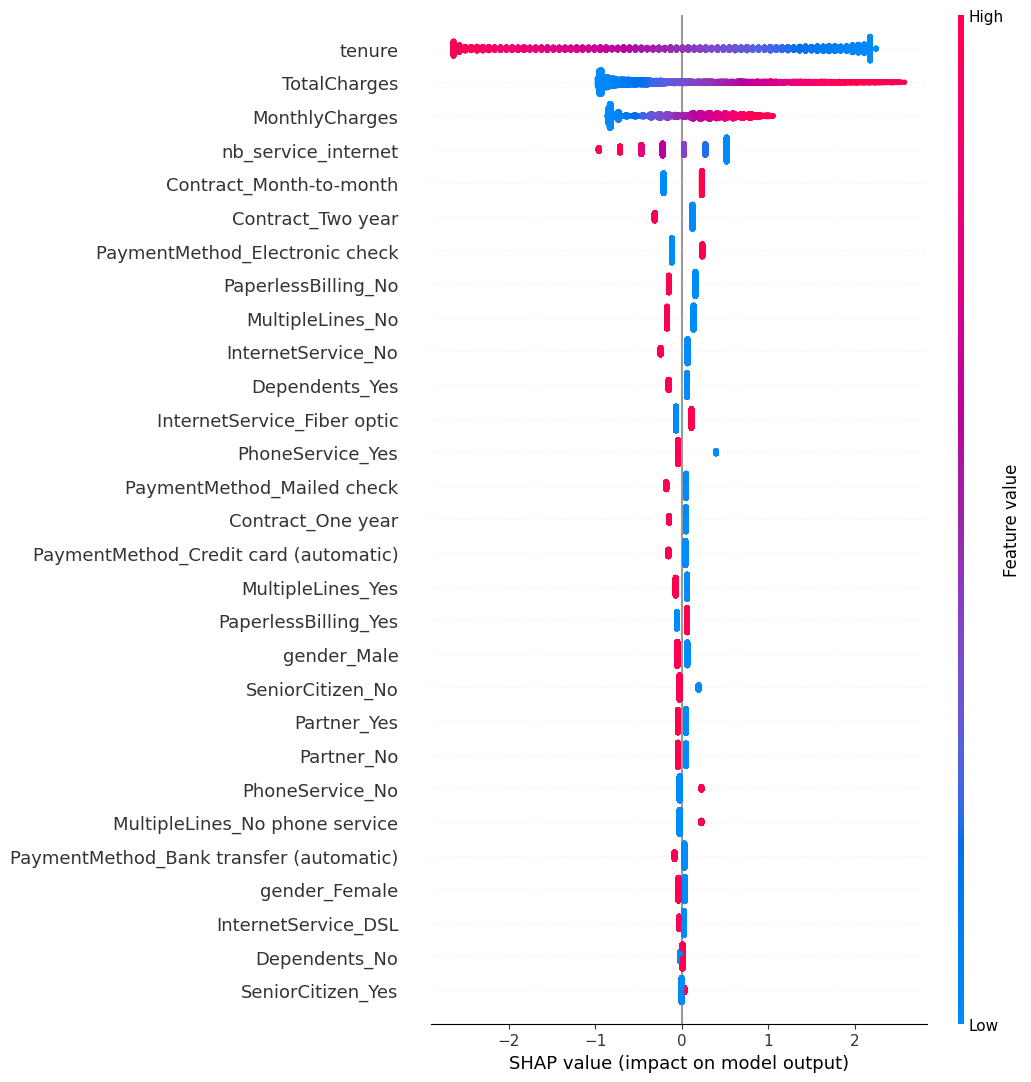

In [460]:
import shap.plots
# Calcule les valeurs SHAP pour les caractéristiques
shap_values = explainer(X_train_transformed)

# Construire le DataFrame de SHAP
shap_values = shap.Explanation(values=shap_values.values, 
                               base_values=shap_values.base_values, 
                               data=X_train_transformed, 
                               feature_names=feature_names)

# Affiche le graphique beeswarm
shap.plots.beeswarm(shap_values, max_display=50)

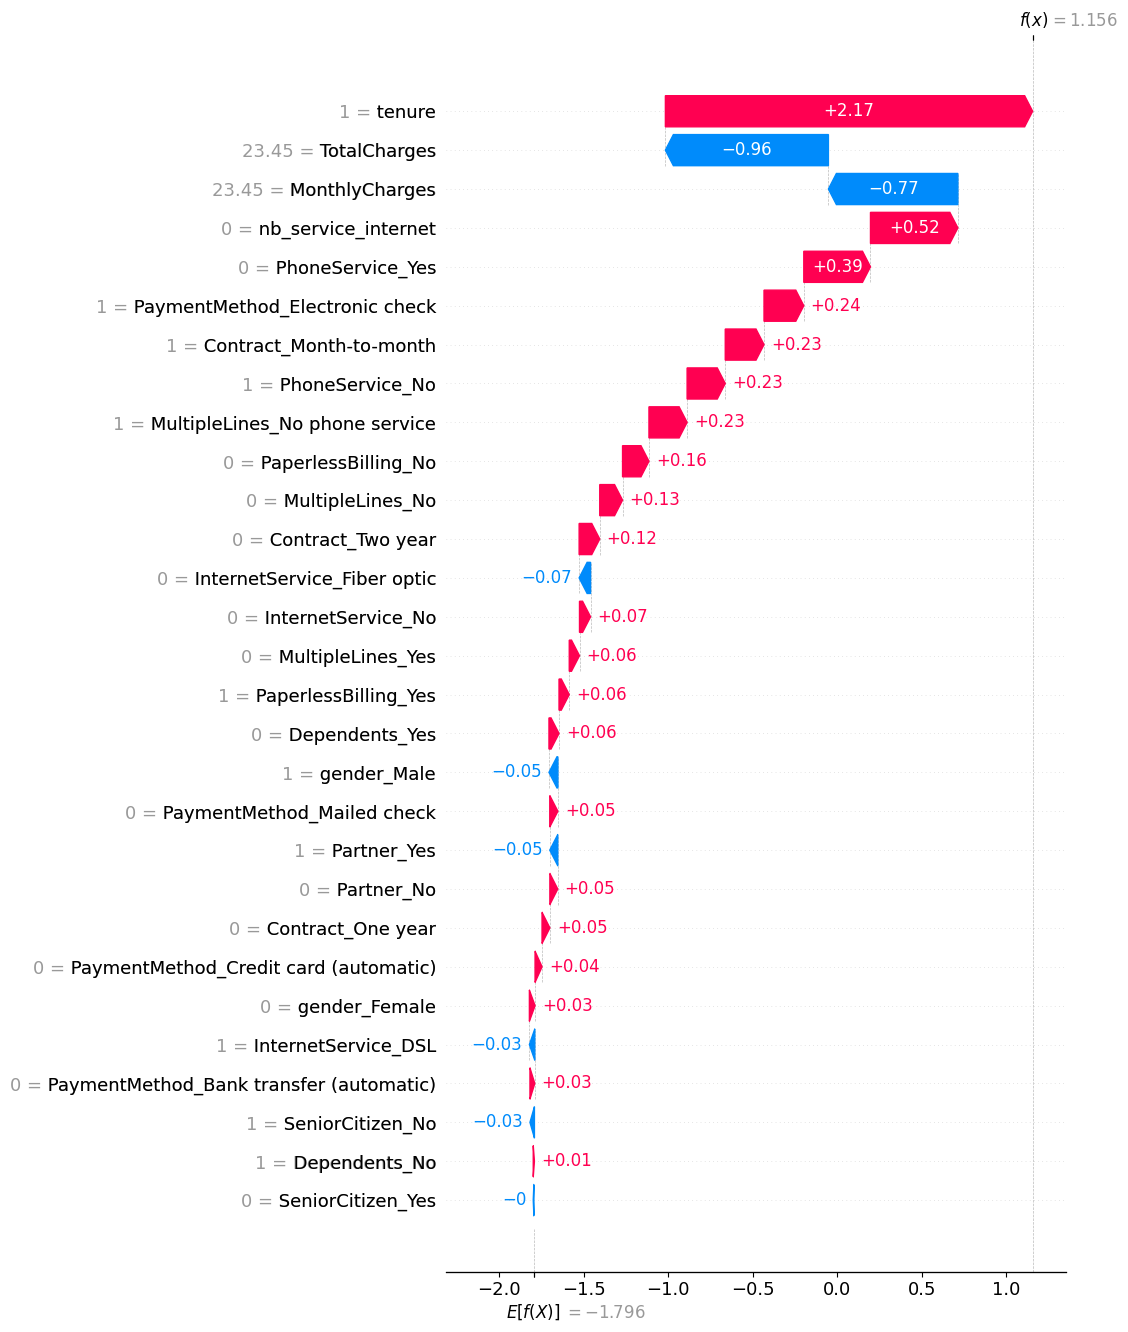

In [461]:
# waterfalls
shap.plots.waterfall(shap_values[2] , max_display=50)

In [462]:
# df des valeurs réel et prédites pour l'entrainement
df_train = pd.DataFrame(X_train_transformed, columns=feature_names)
df_train['y'] = y_train
df_train['y_pred'] = pipe.predict(X_train)

df_train.head(10)

,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,nb_service_internet,y,y_pred
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,21.0,64.85,1336.80,3.0,0,0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,54.0,97.20,5129.45,3.0,0,0
2,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,23.45,23.45,0.0,1,1
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,4.0,70.20,237.95,0.0,1,1
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,61.90,0.00,3.0,0,0
5,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,7.0,69.55,521.35,0.0,0,1
6,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,32.0,18.95,613.95,0.0,0,0
7,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,72.0,19.80,1414.65,0.0,0,0
8,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,19.0,39.65,733.35,2.0,1,1
9,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,10.0,19.95,219.50,0.0,0,0


In [463]:
from scipy.special import expit

# Valeur sur l'échelle du logit
logit_value = -1.796

# Conversion à l'échelle de la probabilité
probability_value = expit(logit_value)

print(probability_value)

0.14233868016703644


## SHAP pour la première observation pour voir comment sa marche

In [465]:
X_train_transformed = X_train_transformed[0]
X_train_transformed = X_train_transformed.reshape(1, -1)

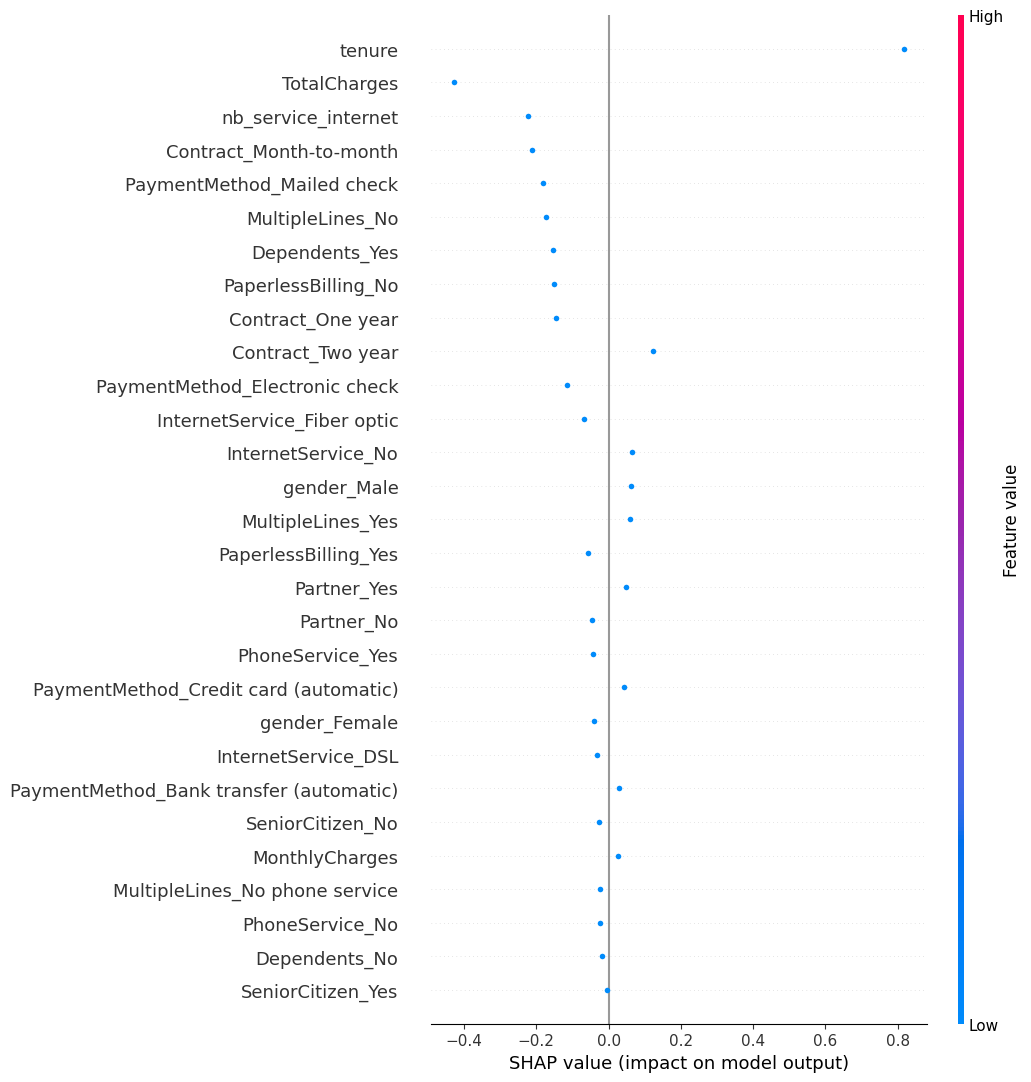

In [466]:
import shap.plots
# Calcule les valeurs SHAP pour les caractéristiques
shap_values = explainer(X_train_transformed)

# Construire le DataFrame de SHAP
shap_values = shap.Explanation(values=shap_values.values, 
                               base_values=shap_values.base_values, 
                               data=X_train_transformed, 
                               feature_names=feature_names)

# Affiche le graphique beeswarm
shap.plots.beeswarm(shap_values, max_display=50)

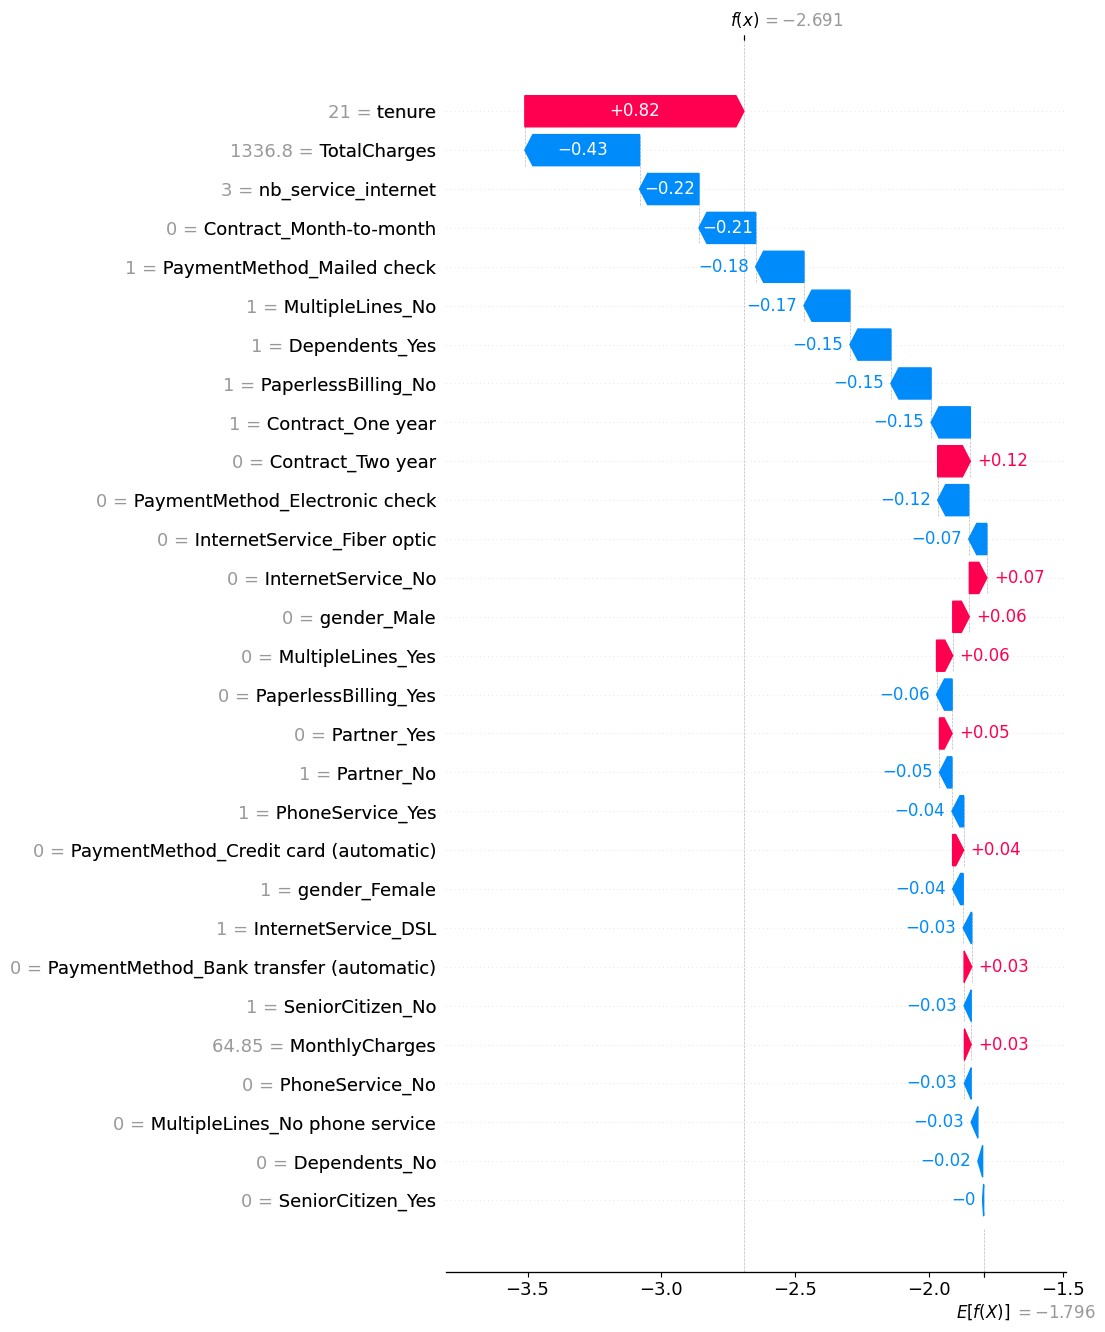

In [467]:
# waterfalls
shap.plots.waterfall(shap_values[0] , max_display=50)

## Prédiction sur les données d'entraînement et de test

Nous utilisons notre pipeline formé pour effectuer des prédictions sur nos ensembles de données d'entraînement et de test. Cela nous permettra d'évaluer les performances de notre modèle.

In [468]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

#  Metrics

In [469]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import numpy as np

# Convert y_pred_train and y_pred_test to numpy arrays
y_pred_train = np.array(y_pred_train)
y_pred_test = np.array(y_pred_test)

print("######## accuracy_score : ")
print("TRAIN :",accuracy_score(y_train, y_pred_train))
print("TEST :",accuracy_score(y_test, y_pred_test))

print("######## f1_score : ")
print("TRAIN :",f1_score(y_train, y_pred_train))
print("TEST :",f1_score(y_test, y_pred_test))

print("######## precision_score : ")
print("TRAIN :",precision_score(y_train, y_pred_train))
print("TEST :",precision_score(y_test, y_pred_test))

print("######## recall_score : ")    
print("TRAIN :",recall_score(y_train, y_pred_train))
print("TEST :",recall_score(y_test, y_pred_test))

######## accuracy_score : 
TRAIN : 0.802626908058218
TEST : 0.8190205819730305
######## f1_score : 
TRAIN : 0.5923753665689151
TEST : 0.6341463414634146
######## precision_score : 
TRAIN : 0.6558441558441559
TEST : 0.6820987654320988
######## recall_score : 
TRAIN : 0.5401069518716578
TEST : 0.5924932975871313


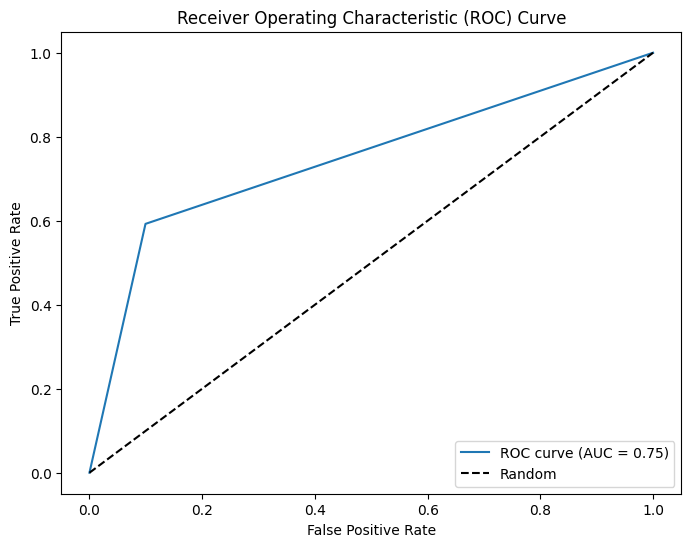

######## roc_auc_score : 
TRAIN : 0.7188209964771531
TEST : 0.7465362240831409


In [470]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("######## roc_auc_score : ")    
print("TRAIN :",roc_auc_score(y_train, y_pred_train))
print("TEST :",roc_auc_score(y_test, y_pred_test))  